# Imports

In [3]:
from pathlib import Path
from dateutil.tz import gettz
from datetime import datetime, timedelta
from numpy import arange
from matplotlib.pyplot import subplots, tight_layout
from matplotlib.dates import DateFormatter
from matplotlib.ticker import AutoMinorLocator, StrMethodFormatter
from pandas import DataFrame, concat
from stk_guide.pipeline.stages.preprocessing import PricePreprocessor
from stk_guide.entities.prices import PricesEnum
from stk_guide.entities.stock import Stock
from stk_guide.entities.stocks import Stocks
from stk_guide.ml.encoding.algorithms import MinMaxCoder
from stk_guide.ml.encoding.encoder import Encoder
from stk_guide.ml.models.gbr import GbrModel
from stk_guide.ml.models.sequence import SequenceModel
from stk_guide.pipeline.pipeline import Pipeline
from stk_guide.pipeline.pipeline_stages import PipelineStages
from stk_guide.pipeline.stages.predicting import PricePredictor
from stk_guide.pipeline.stages.training import ClosePriceTrainer
from stk_guide.strategies.historic_price import HistoricPrice
from stk_guide.entities.options import OptionsEnum
from stk_guide.ml.scoring.scorer import RatingsScorer
from keras import saving
import seaborn as sns
sns.set_style("whitegrid")

# Options Analysis

## Download

In [78]:
screen_stocks = ["AAPL","NVDA","META","INTC","AMZN","GOOGL","MSFT","AVGO", "RDDT", "V", "UBER", "HIMS"]
sns.set_style("whitegrid")
today = datetime.now().strftime("options_%Y.%m.%d")
today_calls = []; 
stocksObj = []
for idx, symbol in enumerate(screen_stocks):
    stock = Stock(symbol)
    stocksObj.append(stock)
    stock.populate_options(max_number=10)

## Price Trending

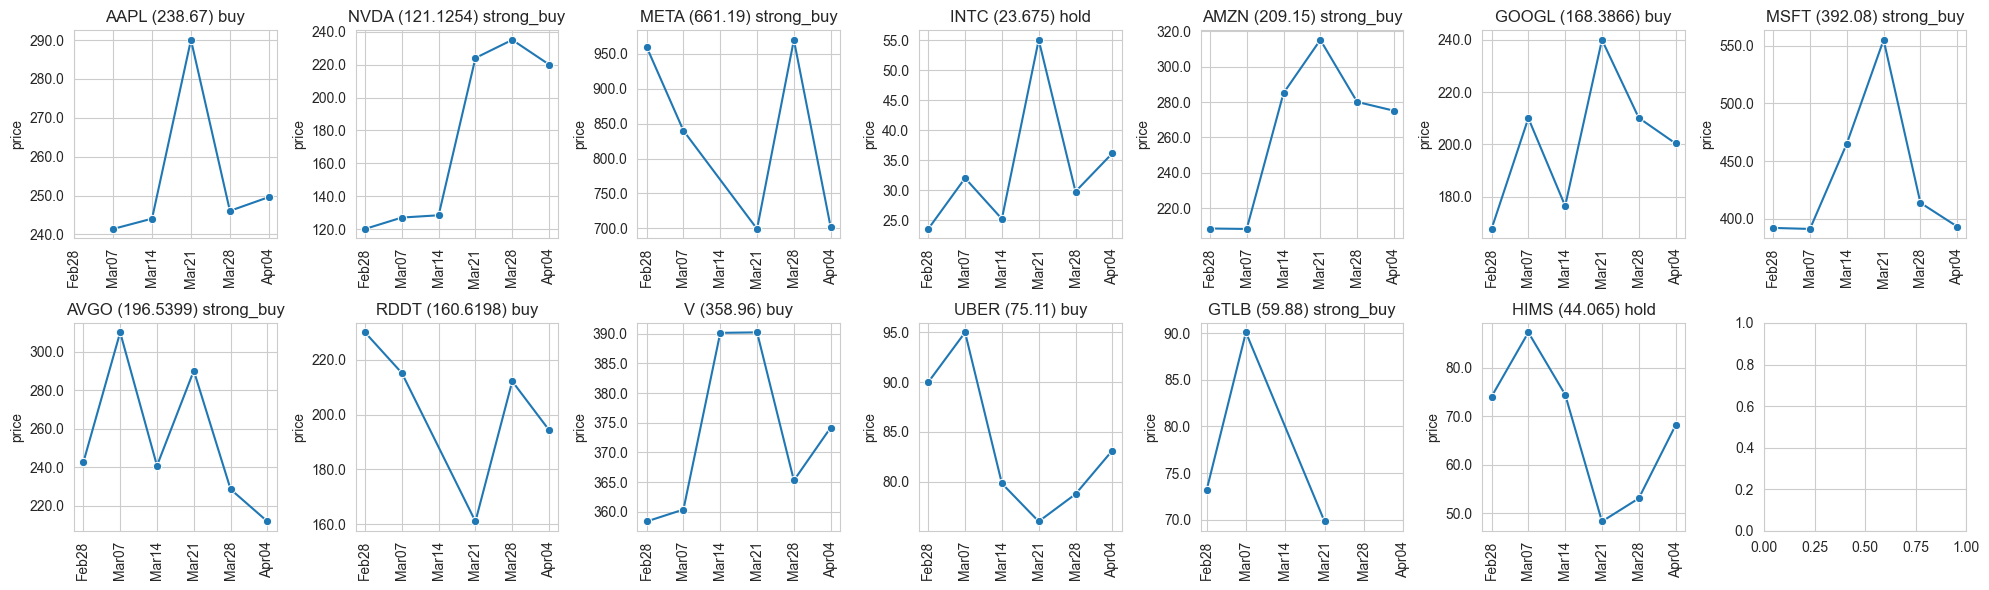

In [6]:
today = datetime.now().strftime("options_%Y.%m.%d")
fig, ax = subplots(nrows=2,ncols=7,figsize=(20,6)); ax = ax.reshape(-1)
today_calls = []; weights = {OptionsEnum.VOLUME:10, OptionsEnum.PERCENTCHANGE:20}
for idx, stock in enumerate(stocksObj):
    try:
        calls,puts = stock.options.sumarize_calls(weights=weights), stock.options.sumarize_puts()
        sns.lineplot(calls,x=OptionsEnum.EXPIRATION,y=OptionsEnum.PROJECTED_PRICE_v1,marker="o",ax=ax[idx])
        ylim = [10,30] if stock.symbol == "INTC" else [0.1,1000]
        ax[idx].set(title=f"{stock.symbol} ({stock.info['currentPrice']}) {stock.info['recommendationKey']}",ylabel="price", xlabel="")#, ylim=ylim);
        dates = [dd.strftime("%b%d") for dd in calls[OptionsEnum.EXPIRATION.value]]
        ax[idx].set_xticks(calls[OptionsEnum.EXPIRATION.value], dates, rotation=90)
        ax[idx].yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
    except Exception:
        pass
tight_layout()

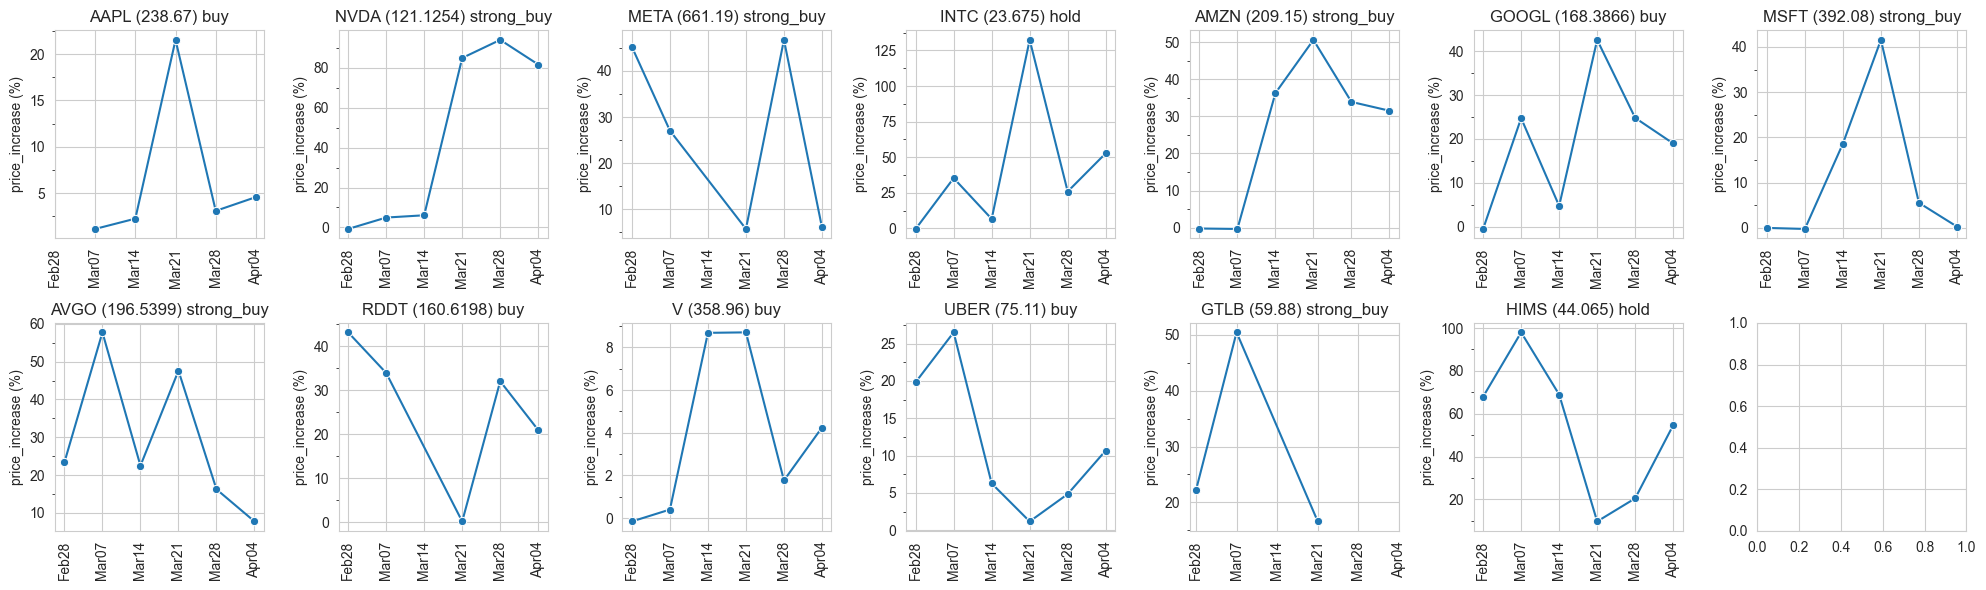

In [7]:
sns.set_style("whitegrid")
today = datetime.now().strftime("options_%Y.%m.%d")
fig, ax = subplots(nrows=2,ncols=7,figsize=(20,6)); ax = ax.reshape(-1)
today_calls = []; 
for idx, stock in enumerate(stocksObj):
    calls,puts = stock.options.sumarize_calls(weights=weights), stock.options.sumarize_puts()
    calls[OptionsEnum.PROJECTED_PRICE_v1] = (calls.loc[:,OptionsEnum.PROJECTED_PRICE_v1]/stock.info['currentPrice'] - 1)*100
    calls[OptionsEnum.PROJECTED_PRICE_v0] = (calls.loc[:,OptionsEnum.PROJECTED_PRICE_v0]/stock.info['currentPrice'] - 1)*100
    sns.lineplot(calls,x=OptionsEnum.EXPIRATION,y=OptionsEnum.PROJECTED_PRICE_v1,marker="o",ax=ax[idx])
    ax[idx].set(title=f"{stock.symbol} ({stock.info['currentPrice']}) {stock.info['recommendationKey']}",ylabel="price_increase (%)", xlabel="")#, ylim=ylim);
    dates = [dd.strftime("%b%d") for dd in calls[OptionsEnum.EXPIRATION.value]]
    ax[idx].set_xticks(calls[OptionsEnum.EXPIRATION.value], dates, rotation=90)
    ax[idx].yaxis.set_minor_locator(AutoMinorLocator(2)); ax[idx].tick_params(which='minor',bottom=True, left=True)
tight_layout()

## Options Upcoming 

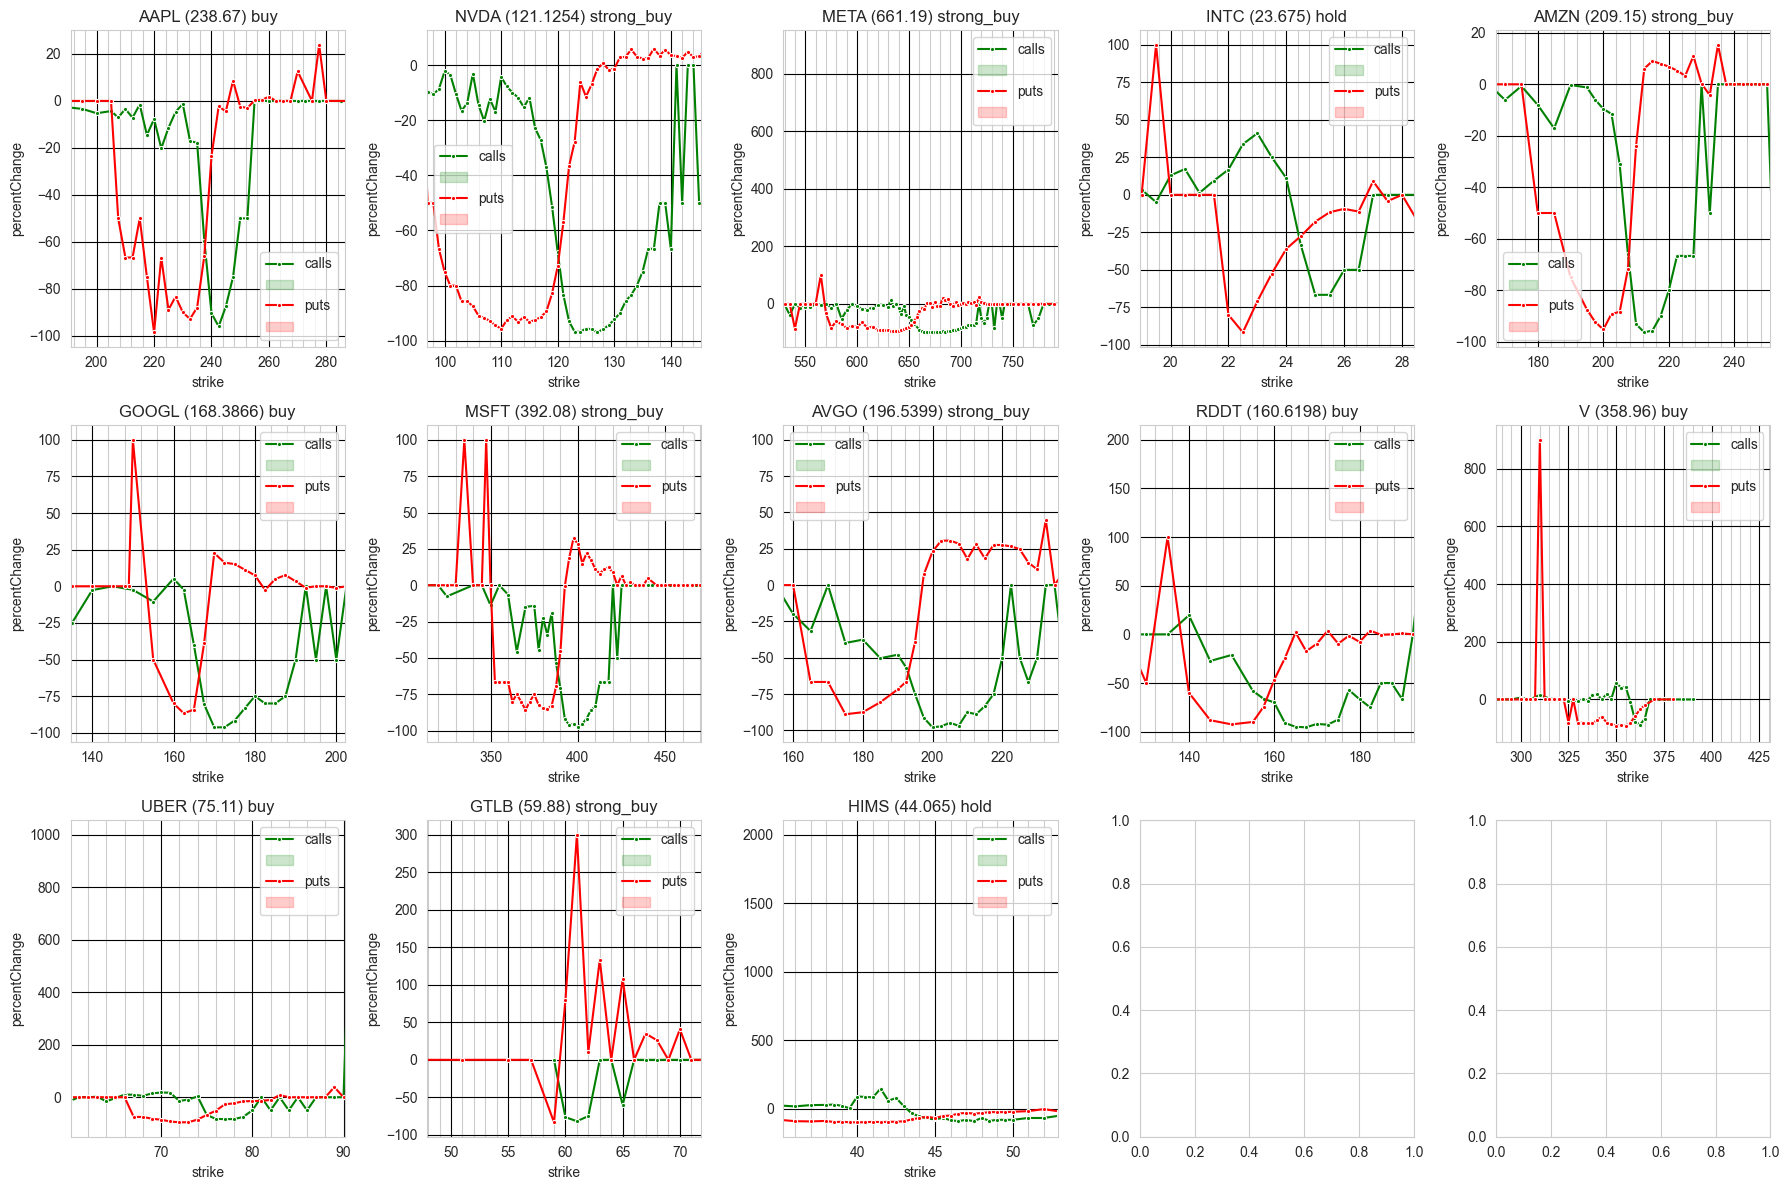

In [8]:
date = datetime(2025,2,28).date()
fig, ax = subplots(nrows=3,ncols=5,figsize=(18,12)); ax = ax.reshape(-1)
to_plot = OptionsEnum.PERCENTCHANGE
for idx, stock in enumerate(stocksObj):
    calls = stock.options.calls.dropna(); puts = stock.options.puts.dropna()
    calls = calls[(calls[OptionsEnum.EXPIRATION.value] == date)]# & (calls[to_plot] > 0)]
    puts = puts[(puts[OptionsEnum.EXPIRATION.value] == date)] #& (puts[to_plot] > 0)]
    sns.lineplot(calls,x=OptionsEnum.STRIKE,y=to_plot,marker=".",ax=ax[idx], color="green")
    sns.lineplot(puts,x=OptionsEnum.STRIKE,y=to_plot,marker=".",ax=ax[idx], color="red")
    for _ax in [ax[idx]]:
        price = stock.info["currentPrice"]
        _ax.set(title=f"{stock.symbol} ({price}) {stock.info['recommendationKey']}",ylabel=f"{to_plot}", xlabel="strike", xlim=[0.8*price, 1.2*price])
        _ax.grid(color="black")
        _ax.xaxis.set_minor_locator(AutoMinorLocator(5)); _ax.xaxis.set_tick_params(which='minor',gridOn=True);
        _ax.legend(["calls",None, "puts", None])
tight_layout()


## Options Future

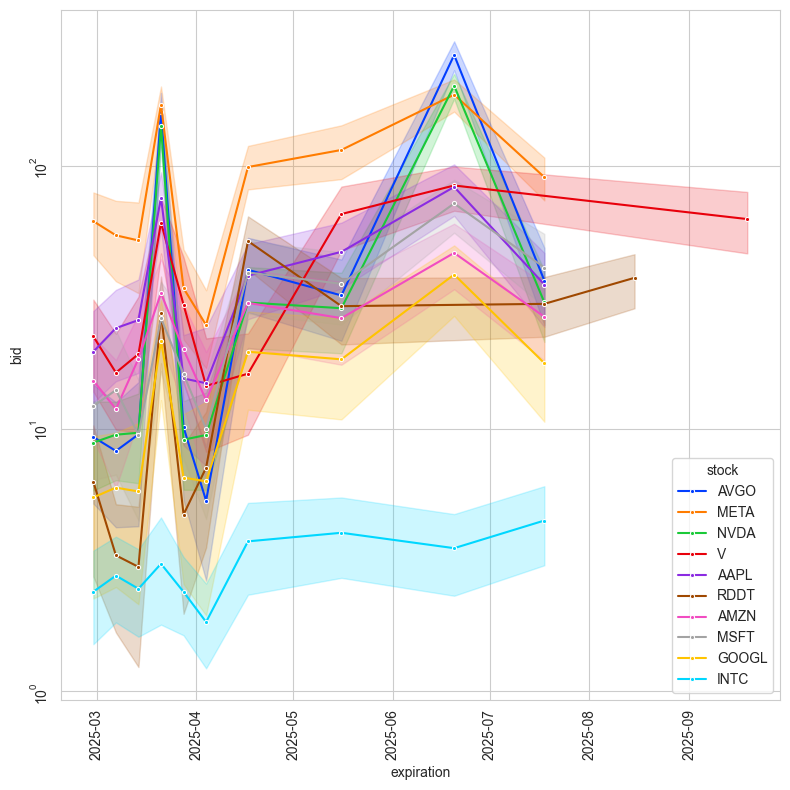

In [88]:
date = datetime(2026,4,5).date()
fig, ax = subplots(nrows=1,ncols=1,figsize=(8,8))
to_plot = OptionsEnum.BID
df = []
for idx, stock in enumerate(stocksObj):
    if stock.symbol in ["HIMS", "UBER"]: continue
    calls = stock.options.calls.dropna(); puts = stock.options.puts.dropna()
    calls = calls[(calls[OptionsEnum.EXPIRATION.value] < date)]
    calls["stock"] = stock.symbol
    df.append(calls)
df = concat(df)
_max = {}
for (stk, exp),_df in df.groupby(["stock",OptionsEnum.EXPIRATION]):
    if stk not in _max: 
        _max[stk] = []
    _max[stk].append(_df[OptionsEnum.BID].median())
order = [stk[0] for stk in sorted([(stk,max(vals)) for stk,vals in _max.items()], key=lambda x: x[1], reverse=True)]
palette = sns.color_palette("bright")
sns.lineplot(df,x=OptionsEnum.EXPIRATION,y=to_plot,marker=".",ax=ax, hue="stock", hue_order=order, palette=palette); ax.set(yscale="log")
    # puts = puts[(puts[OptionsEnum.EXPIRATION.value] == date)] #& (puts[to_plot] > 0)]
ax.tick_params(rotation=90);
tight_layout()


In [ ]:
# stock_symbols = "TSLA,AAPL,NVDA,AMZN,MSFT,F,AMC,VOO,SPY,DIS,SNDL,VWO,VEA,BND,META,GOOGL,NIO,VTI,IVV,AMD,LCID,NFLX,PLTR,SPMO,RIVN,QQQ,PFE,GME,SNAP,KO,PLUG,BABA,WMT,HOOD,ACB,AAL,BAC,SBUX,CCL,QUAL,TLRY,INTC,SCHD,VB,DAL,DJT,NOK,COST,T,TSM,COIN,VONG,SOFI,UBER,IJR,GE,GOOG,PYPL,NKE,XOM,AVGO,BA,BRK.B,SOUN,PSEC,BB,GM,CRWD,MRNA,CHPT,JNJ,VYM,ET,CRON,JPM,XYZ,RBLX,RIOT,MSTR,O,ABNB,DKNG,NCLH,V,ARKK,LUV,PANW,SHOP,SPYG,LLY,UAL,MU,VZ,TGT,JBLU,SPHQ,PTON,SPHD,SCHG,VUG"
# stocksObjLong = []
# for symbol in stock_symbols.split(","):
#     stock = Stock(symbol)
#     try:
        
#         stock.populate_options(max_number=6)
#     except Exception:
#         pass
#     stocksObjLong.append(stock)

# Recommendations

## Finhub + Robinhood

In [10]:
# GET THE DATA
news, rratings, fratings, recom = [], [], [], []
for idx, symbol in enumerate(screen_stocks):
    stock = Stock(symbol)
    rratings.append(stock.robinhood_ratings[0].to_frame())
    fratings.append(stock.finhub_ratings[0].to_frame())
    recom.append(stock.info["recommendationKey"])
robin_ratings = concat(rratings); robin_ratings.index = screen_stocks
fin_ratings = concat(fratings); fin_ratings.index = screen_stocks
recom = DataFrame(recom, index=screen_stocks)


In [11]:
# SCORE LATEST
robin_results, fin_results = [],[]; weights = arange(0,1.1,0.1);
for ww in weights:
    scr = RatingsScorer(hold_weight=ww)
    df = scr(robin_ratings).to_frame(); df["stock"] = robin_ratings.index.to_list(); df["holdw"] = ww
    robin_results.append(df)
    df = scr(fin_ratings).to_frame(); df["stock"] = fin_ratings.index.to_list(); df["holdw"] = ww
    fin_results.append(df)
robin_results = concat(robin_results); robin_results["src"] = "Robinhood"
fin_results = concat(fin_results); fin_results["src"] = "Finhub"
robin_results["scores"] = 1 - robin_results["scores"]
fin_results["scores"] = 1 - fin_results["scores"]

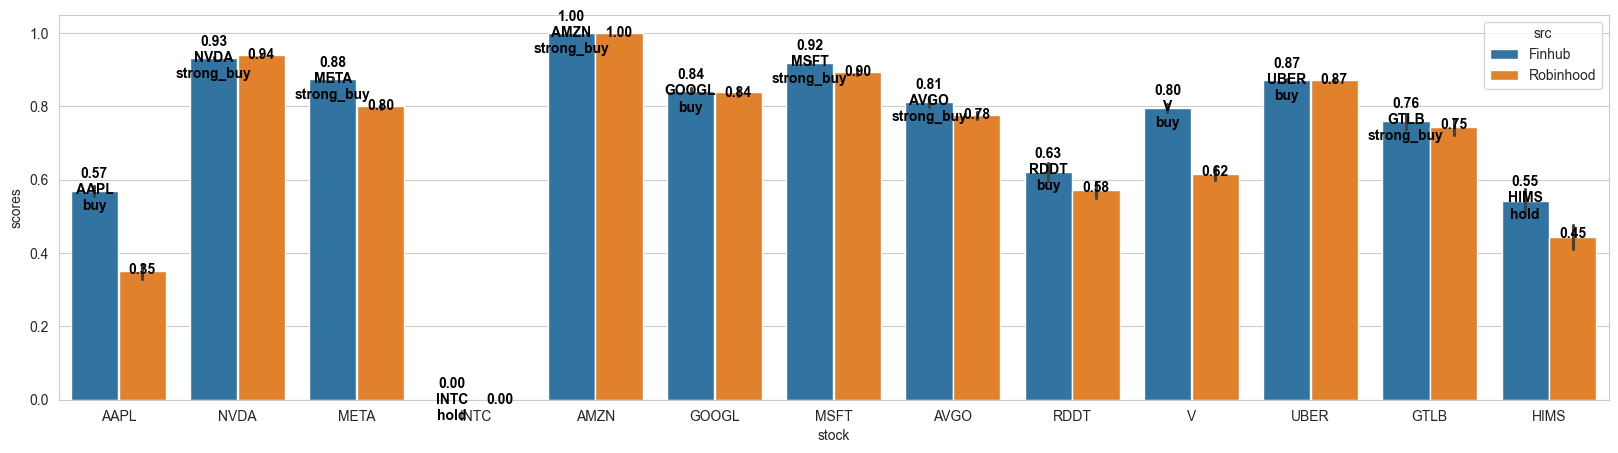

In [12]:
# PLOT
results = concat([robin_results, fin_results])
fig, ax = subplots(nrows=1,ncols=1,figsize=(20,5)); names = ["Finhub","Robinhood"]
all_vals = results.groupby(["src","stock"]).median();
sns.barplot(results, x="stock", y="scores", hue="src", gap=0.01, ax=ax, hue_order=names);
lines = ax.get_lines() 
for idx, line in enumerate(lines):
    x = line.get_xdata()[0]
    name = screen_stocks[idx%len(screen_stocks)]; src = names[0 if idx < len(screen_stocks) else 1]
    value = all_vals.loc[(src, name),"scores"]
    rmd = recom.loc[name]
    if idx < len(screen_stocks):
        text = ax.text(x, value, f'{value:.2f}\n{name}\n{rmd.iloc[0]}', ha='center', va='center',fontweight='bold', color='black')
    else :
        text = ax.text(x, value, f'{value:.2f}', ha='center', va='center',fontweight='bold', color='black')


## FinHub Rating Change

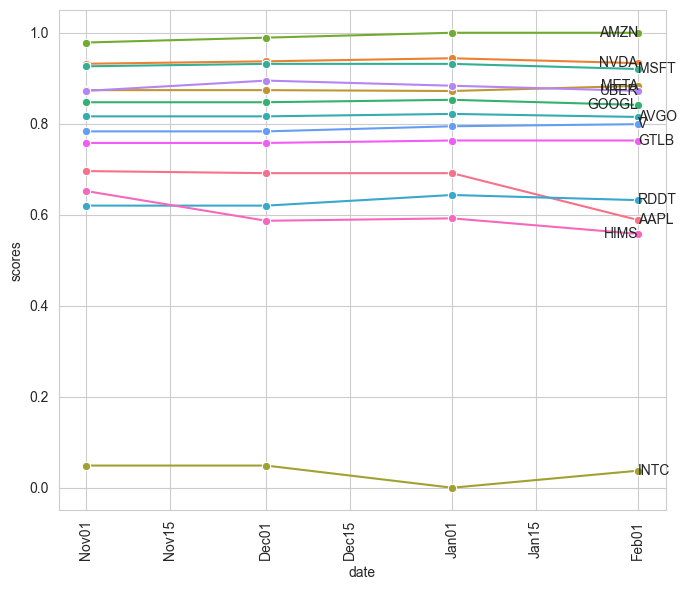

In [13]:
# GET THE DATA
fratings = []
for idx, symbol in enumerate(screen_stocks):
    stock = Stock(symbol)
    _fratings = concat(rating.to_frame() for rating in stock.finhub_ratings)
    _fratings["stock"] = symbol
    fratings.append(_fratings)
fin_ratings = concat(fratings).reset_index(drop=True); 
scr = RatingsScorer(hold_weight=0.5)
fin_ratings["scores"] = 1 - scr(fin_ratings)
fig, ax = subplots(nrows=1,ncols=1,figsize=(7,6));
sns.lineplot(fin_ratings,x="date",y="scores",marker="o",ax=ax, hue="stock")
for idx,(ss,_names) in enumerate(fin_ratings.sort_values("scores")[["date","scores","stock"]].groupby("stock")):
    x,y = _names.sort_values("date", ascending=False)[["date","scores"]].iloc[0]
    ax.text(x,y,ss,ha=("left" if idx%2 == 0 else "right"), va="center")
ax.legend().set_visible(False)
[xx.set_rotation(90) for xx in ax.get_xticklabels()]; ax.xaxis.set_major_formatter(DateFormatter("%b%d"))
tight_layout()

# Find Best Options